In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

## Data analysing and cleaning

In [2]:
train_path = './data/train.csv'
test_path = './data/test.csv'
data_path = './data/data.csv'


In [3]:
train_df = pd.read_csv(train_path)

In [4]:
train_df.head()

,City,Restaurant,Date,Weekly_Sales,IsHoliday
0,1,1,05-02-10,24924.50,False
1,1,1,12-02-10,46039.49,True
2,1,1,19-02-10,41595.55,False
3,1,1,26-02-10,19403.54,False
4,1,1,05-03-10,21827.90,False


In [5]:
test_df = pd.read_csv(test_path)

In [6]:
test_df.head()

,City,Restaurant,Date,IsHoliday
0,1,1,06-01-12,False
1,1,1,13-01-12,False
2,1,1,20-01-12,False
3,1,1,27-01-12,False
4,1,1,03-02-12,False


### Drop restaurants from train that doesnt exist in test

In [7]:
train_df = pd.merge(train_df,test_df[['City','Restaurant']].drop_duplicates(), on=['City','Restaurant'],how='inner')
train_df['Date'] = pd.to_datetime(train_df['Date'], dayfirst=True, format='%d-%m-%y')

In [8]:
train_df.head()

,City,Restaurant,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [9]:
city_df = pd.read_csv(data_path)
city_df['Date'] = pd.to_datetime(city_df['Date'], dayfirst=True, format='%d-%m-%y')

In [10]:
city_df.head()

,City,Date,Temperature,Fuel_Price,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,8.106,False
1,1,2010-02-12,38.51,2.548,8.106,True
2,1,2010-02-19,39.93,2.514,8.106,False
3,1,2010-02-26,46.63,2.561,8.106,False
4,1,2010-03-05,46.50,2.625,8.106,False


In [11]:
city_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3640 entries, 0 to 3639
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   City          3640 non-null   int64         
 1   Date          3640 non-null   datetime64[ns]
 2   Temperature   3640 non-null   float64       
 3   Fuel_Price    3640 non-null   float64       
 4   Unemployment  3380 non-null   float64       
 5   IsHoliday     3640 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1)
memory usage: 145.9 KB


### Analyse data for each unique restaurant

In [12]:
size = train_df.groupby(['Restaurant','City']).size()
print(f'Min value: {min(size)}, max : {max(size)}')

Min value: 1, max : 100


Not all restaurants have full data, need to fill every unique restaurant to max

### Create time series for each unique restaurant

Each df has to be indexed with dates, have exactly 100 values (NaN's are filled with mean)

In [13]:
def get_ts_df(city_id, restaurant_id,with_exog=False, df=train_df, city_df=city_df):
    ts_df = df[(df['City'] == city_id) & (df['Restaurant'] == restaurant_id)].set_index('Date')
       
    idx_range = pd.date_range(start = min(df['Date']), end = max(df['Date']),freq='7D')
    ts_df = ts_df.reindex(idx_range)
    
    ts_df['Weekly_Sales'] = ts_df['Weekly_Sales'].fillna( ts_df['Weekly_Sales'].mean() )
    
    if with_exog:
        city_info = city_df[ city_df['City'] == city_id ].set_index('Date')
        ts_df = pd.merge(ts_df, city_info,left_index=True, right_index=True, on=['City','IsHoliday'])
        ts_df.update(city_info['IsHoliday'])         
    else:
        ts_df = ts_df.drop(['IsHoliday'],axis=1)
    
    ts_df = ts_df.drop(['City','Restaurant'],axis=1)
    return ts_df

In [14]:
ts_df = get_ts_df(1,2)

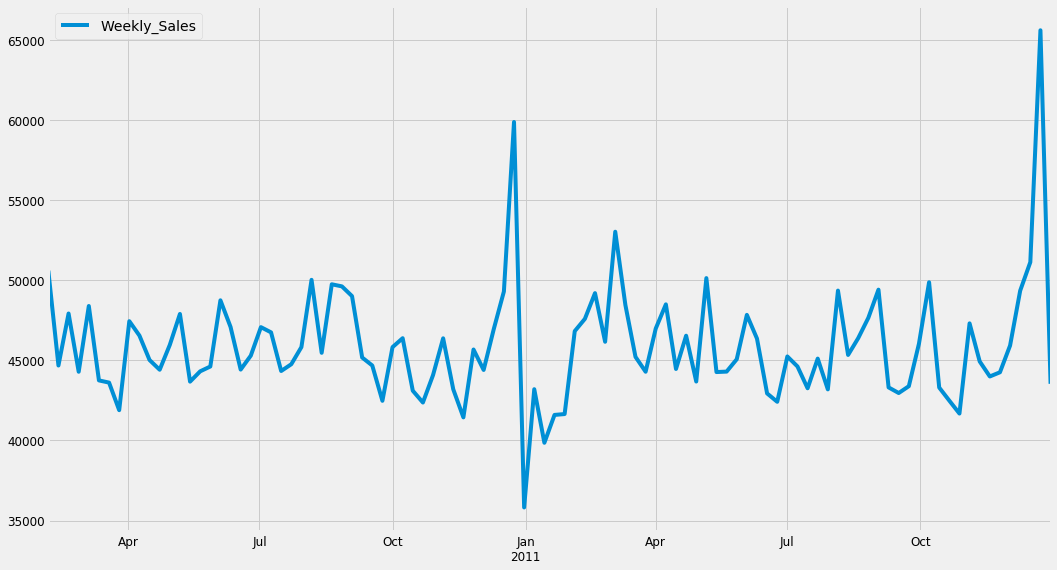

In [15]:
ts_df.plot()

### Time series decomposition

In [16]:
import statsmodels.api as sm

In [17]:
decomposition = sm.tsa.seasonal_decompose(ts_df,period=4)

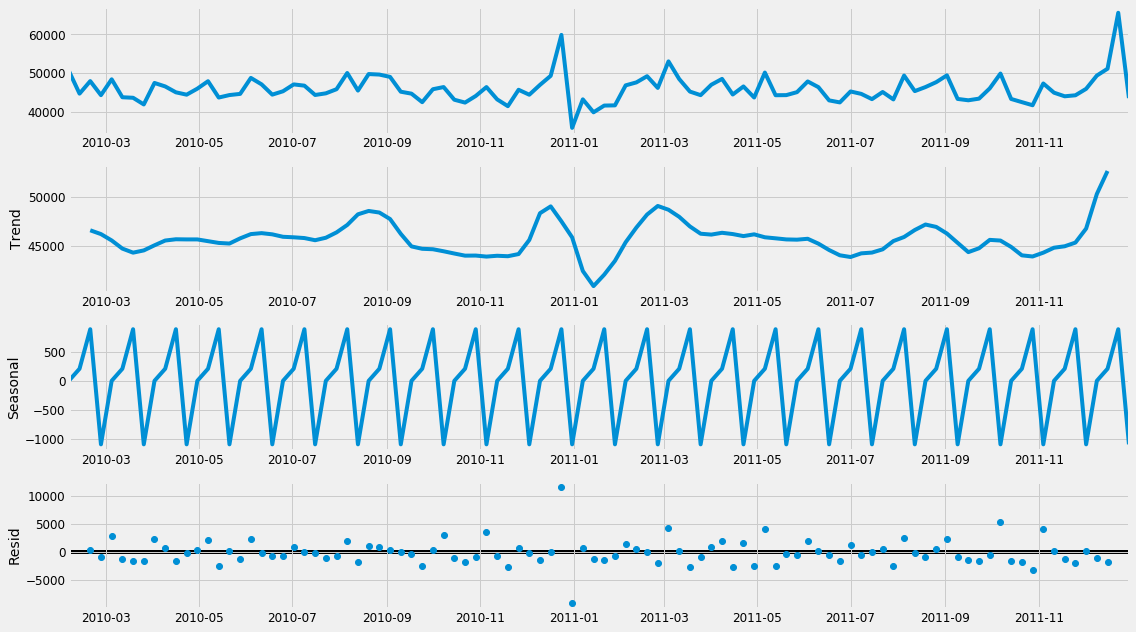

In [18]:
fig = decomposition.plot()
plt.show()

## Models

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [20]:
 ts_train, ts_test = train_test_split(ts_df, test_size=0.2, shuffle=False)

In [21]:
def plot_dif(predicted_x,predicted_y, actual):
    fig = plt.figure(facecolor='w', figsize=(16,9))
    ax = fig.add_subplot(111)
    ax.plot(actual.index,actual['Weekly_Sales'],label='observed')
    
    ax.plot(predicted_x,predicted_y,label='predicted')
    
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Restaurant Sales')
    plt.title('Observed vs Predicted')
    plt.show()

### FB Prophet

In [22]:
from fbprophet import Prophet

In [23]:
def to_fb_format(df):
    return pd.DataFrame({'ds':df.index,'y':df['Weekly_Sales']}).reset_index(drop=True)

In [24]:
ts_train_fb = to_fb_format(ts_train)
ts_test_fb = to_fb_format(ts_test)

In [25]:
m = Prophet(yearly_seasonality=True)
m.fit(ts_train_fb)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
forecast = m.predict(ts_test_fb)

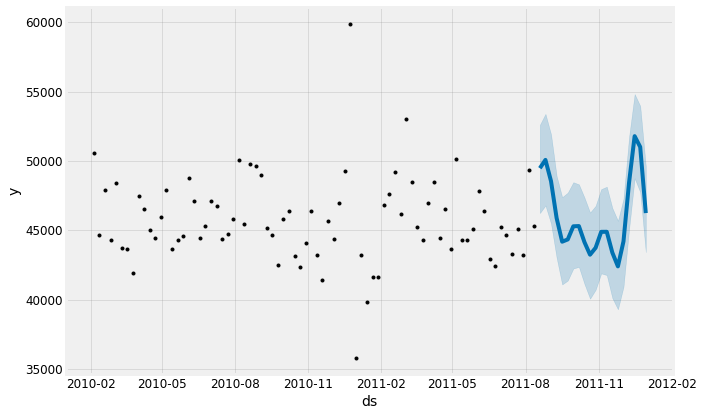

In [27]:
fig1 = m.plot(forecast)

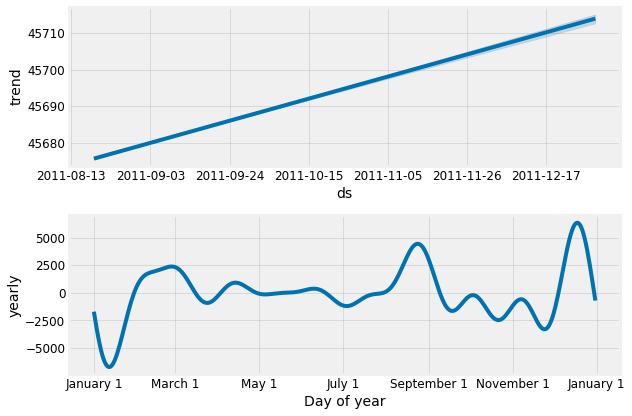

In [28]:
fig2 = m.plot_components(forecast)

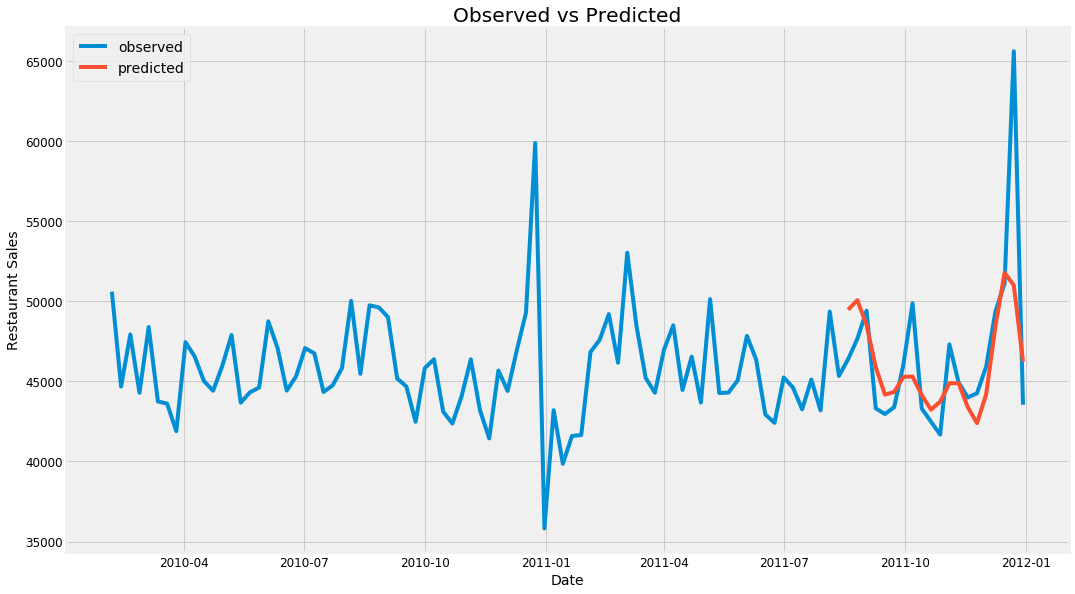

In [29]:
plot_dif(forecast['ds'],forecast['yhat'], ts_df)

In [30]:
fb_rmse = np.sqrt(mean_squared_error(ts_test_fb['y'],forecast['yhat']))
print(f'RMSE: {fb_rmse}')

RMSE: 3787.3953648288134


### ARIMA

### Grid search

In [31]:
import itertools

In [32]:
import warnings
warnings.filterwarnings(action='once')

In [212]:
def grid_search_arima(train,pdq_range=3,periods=12,exog=None):
    p = d = q = range(pdq_range)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], periods) for x in pdq]
    best_AIC = np.inf
    best_params = ()

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(train,
                                                order=param,
                                                exog=exog,
                                                seasonal_order=param_seasonal,
                                                time_varying_regression=True,
                                                mle_regression=False,
                                                trend='t')
                results = model.fit()
                if results.aic < best_AIC:
                    bestAIC = results.aic
                    best_params = (param, param_seasonal)
            except:
                continue
    print('The best ones are:', best_AIC, best_params)

In [210]:
ts_df = get_ts_df(1,2,with_exog=True)

In [201]:
endog = ts_df['Weekly_Sales']

In [202]:
exog = ts_df.drop(['Weekly_Sales'], axis=1)
exog['IsHoliday'] = exog['IsHoliday'].astype(int)

In [203]:
endog_train, endog_test, exog_train, exog_test = train_test_split(endog, exog, test_size=0.2, shuffle=False)

In [213]:
grid_search_arima(endog_train,exog=exog_train)

D:\Software\Anaconda3\envs\apro\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

D:\Software\Anaconda3\envs\apro\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\Software\Anaconda3\envs\apro\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:994: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

D:\Software\Anaconda3\envs\apro\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

D:\Software\Anaconda3\envs\apro\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



The best ones are: inf ((2, 2, 2), (2, 2, 2, 12))


In [215]:
model = sm.tsa.statespace.SARIMAX(endog_train,
                                            order=(2,2,2),
                                            seasonal_order=(2,2,2,12),
                                              exog=exog_train,
                                  time_varying_regression=True,
                                  mle_regression=False
                                  ,trend='t')

In [216]:
results = model.fit()

In [217]:
print(results.summary().tables[1])

                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
drift                0.3359     14.541      0.023      0.982     -28.164      28.836
ar.L1               -0.8496      3.984     -0.213      0.831      -8.659       6.960
ar.L2               -0.3607      3.781     -0.095      0.924      -7.772       7.051
ma.L1               -0.0711      1.547     -0.046      0.963      -3.104       2.962
ma.L2               -0.1512      1.592     -0.095      0.924      -3.272       2.969
ar.S.L12             0.2393      9.578      0.025      0.980     -18.533      19.011
ar.S.L24            -0.1828      5.565     -0.033      0.974     -11.090      10.725
ma.S.L12             0.6308      1.934      0.326      0.744      -3.160       4.421
ma.S.L24            -0.3689      7.490     -0.049      0.961     -15.048      14.311
var.IsHoliday        0.9999   1.26e+07   7.94e-08      1.000   -2

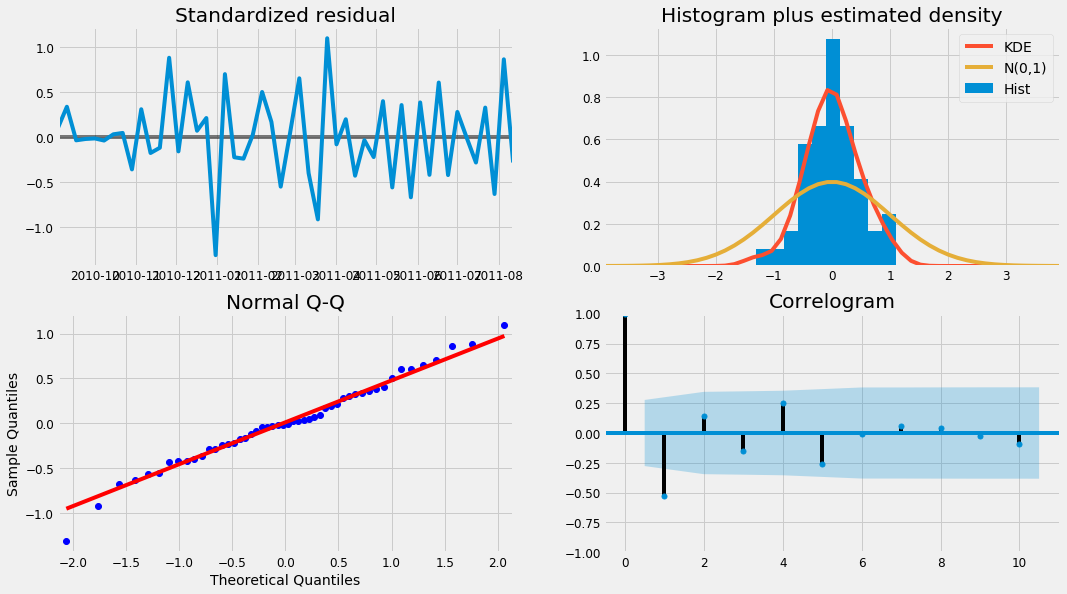

In [218]:
fig = results.plot_diagnostics()

In [219]:
predictions = results.predict(start=min(endog_test.index),end=max(endog_test.index),exog=exog_test) 

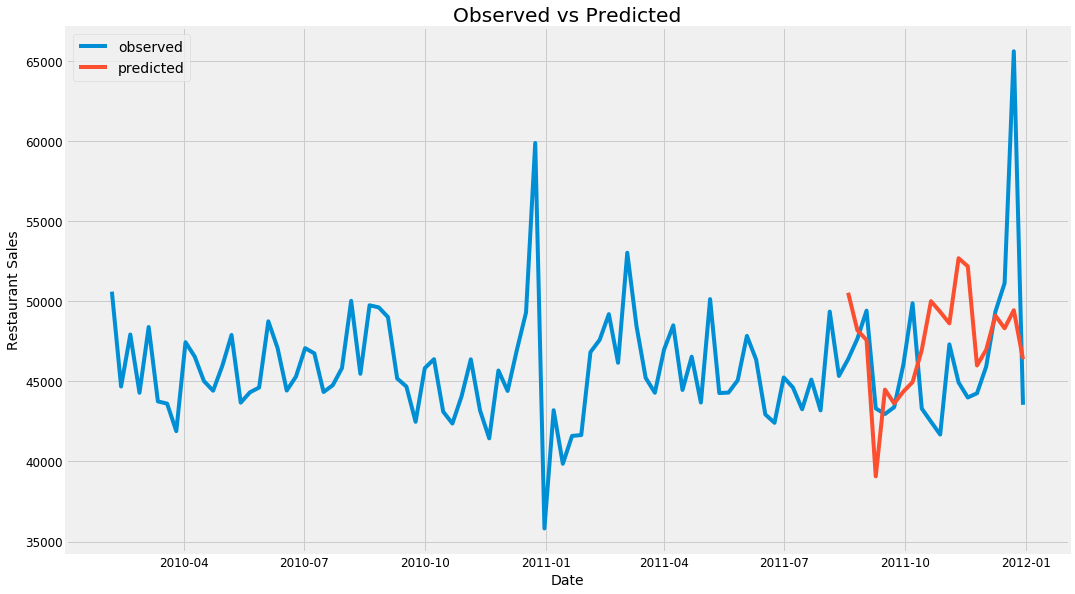

In [220]:
plot_dif(predictions.index,predictions.values, ts_df)

In [221]:
arima_rmse = np.sqrt(mean_squared_error(endog_test,predictions.values))
print(f'RMSE: {arima_rmse}')

RMSE: 5511.588697375672
